## Factor analysis simulation
Use a Reccurent Neural Networ with 16 units trained on a simple control task to demonstrate factor analysis

In [1]:
import torch

from RNNAgent import Agent
import numpy as np
from matplotlib import pyplot as plt 
import gymnasium as gym
import pickle
from playloop import Environment
from scipy.ndimage import gaussian_filter

## The Task

The cartpole control task is a standard Reinforcement Learning benchmark. A massive pole is attached at a frictionless hinge to a massive cart that can move in one dimension along a track. The agent can apply a 1d force to the cart parallel to the track.
The agents goal is to balance the pole vertically upright as long as possible by moving the cart.
The pole is subject to small random pertubation, so the agent must continuously react.

In the standard formulation, the agent has access to four real number observations from the environment at each time step, [Cart position, Cart Velocity, Pole position, and Pole velocity]. That formulation makes the task Markovian (optimal solution can be found using only information provided the current environment state) and thus makes temporal dynamics irrelevant. 

In this analysis, we give the agent only positional information, so it must integrate information over time. At each time step the agent recieves only [position cart, position pole]. Thus we require an RNN that can store information between time steps, and this makes this a good simulation for factor analysis.

The RNN is trained using the soft advantage actor critic policy gradiant algorithm on a per-episode basis.

In [2]:
# load pretrained GRU network
with open("models/gru_factor_8.pkl", "rb") as f:
    rnn = pickle.load(f)
rnn.train = True

Now we collect data from the GRU to do the factor analysis.

We run the agent 10 times and collect the states of each unit at each time step - equivalent to perfect intracellular recordings of each neuron in a population. 

We run the agent a final time for testing

In [13]:
# run an episode for our viewing pleasure
n_episodes = 10
rnn.reset()
env = Environment(rnn, batch_size=1)
_, _, _, _, _, lifespans, obs, actions = env.play(human=True)
test_state = np.concatenate(rnn.state_history, axis=0)
test_actions = actions
states = []
# generate some more example episodes and states
for i in range(n_episodes):
    rnn.reset()
    env.play()
    states += rnn.state_history
print(lifespans)

[499]


Below we compose the full **<time, units>** state matrix for all episodes, and extact some known quantities from the test episode. We extract here the true velocity information even though the agent didn't have access to it, so we can check to see if it's represented in the model. 

In [14]:
states = np.concatenate(states, axis=0)
obs = obs.squeeze()
cart_velocity = obs[:, 1]
pole_velocity = obs[:, 3]
cart_pos = obs[:, 0]
pole_pos = obs [:, 2]

### Computing the factors

The simplest way to compute factors is by PCA. Here we consider each time point an observation and extract 16 (number of units) eigenvectors.

In [15]:
# natural factorization 
cov = np.cov(states.T)
eval, evec = np.linalg.eig(cov)

<BarContainer object of 16 artists>

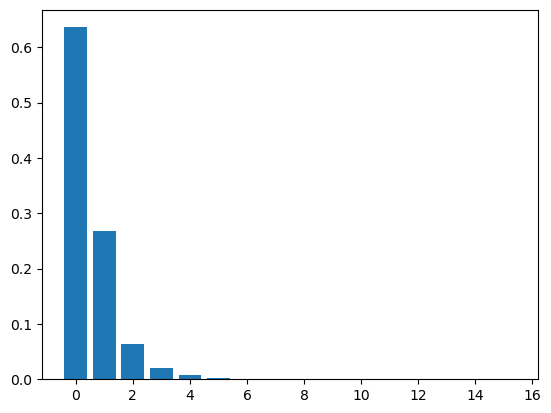

In [16]:
pvar = eval / np.sum(eval)
plt.bar(np.arange(len(pvar)), pvar)

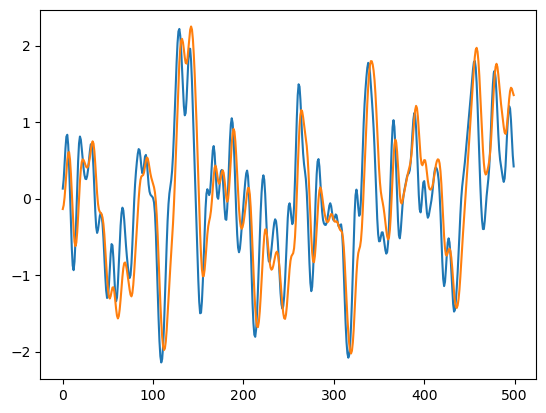

In [19]:
# Factor 0 captures 71 % of variance
primary_factor = test_state @ evec[:, 0]
s_primary_factor = (primary_factor - primary_factor.mean()) / primary_factor.std()
s_primary_factor = gaussian_filter(s_primary_factor, sigma=2)

s_actions = (test_actions - test_actions.mean()) / test_actions.std()
s_actions = (actions - actions.mean()) / actions.std()
s_actions = gaussian_filter(s_actions, sigma=2)

plt.plot(np.arange(lifespans[0] + 1), s_actions.squeeze())
plt.plot(np.arange(lifespans[0] + 1), s_primary_factor)

While these curves closely match, int this type of analysis, we can never know exactly the true readouts the brain is using, and manifold estimators such as PCA make assumption, e.g. we should construct a basis by variance explained. If we plot this same time course using the true readouts, known because we built this system, we get the below:  

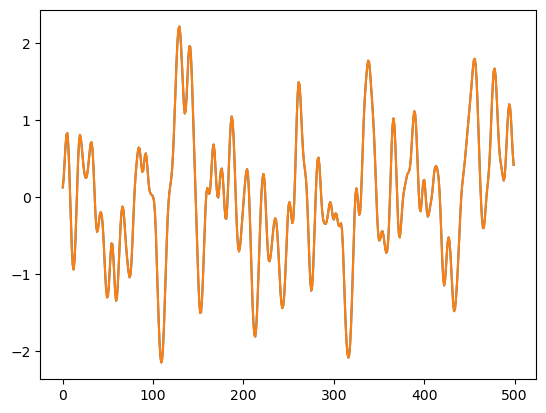

In [18]:
readout_weights = rnn.readout.detach().cpu().numpy()
readout = test_state @ readout_weights
s_readout = (readout - readout.mean()) / readout.std()
s_readout = gaussian_filter(s_readout, sigma=2)
plt.plot(np.arange(lifespans[0] + 1), s_readout)
plt.plot(np.arange(lifespans[0] + 1), 1 * s_actions.squeeze())

This is quite close to the primary factor estimated form PCA, so in this example it seems we're doing alright!

### Can we determine what the other factors are doing?
What about the other factors? Below we find the factor must correlated with variables we believe to be important for the problem - velocity and postion of the cart and pole.  

In [25]:
def get_correlated_factor(quant):
    # get corr of each dim with actions
    all_state_factors = test_state @ evec[:, :6]
    all_state_factors = all_state_factors / np.linalg.norm(all_state_factors, axis=0)[None,...]
    quant = quant / np.linalg.norm(quant, axis=0)[None,...]
    corr = np.dot(all_state_factors.T, quant)
    return np.argmax(np.abs(corr), axis=0)
variables = {"cart V": cart_velocity, "pole V": pole_velocity, "action": test_actions.squeeze()}
for i, name in enumerate(variables):
    q = variables[name]
    best = get_correlated_factor(q)
    print(name, "best explained by:", best)

cart V best explained by: 2
pole V best explained by: 2
action best explained by: 0


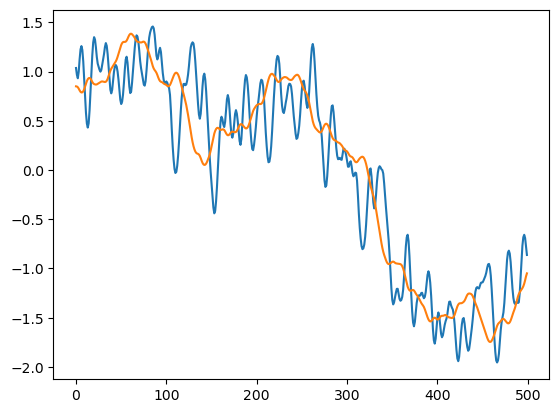

In [20]:
# Factor 1 represents the position of the cart.
primary_factor = test_state @ evec[:, 1]
s_primary_factor = (primary_factor - primary_factor.mean()) / primary_factor.std()
s_primary_factor = gaussian_filter(s_primary_factor, sigma=1)
s_actions = (cart_pos - cart_pos .mean()) / cart_pos.std()
s_actions = gaussian_filter(s_actions, sigma=1)
plt.plot(np.arange(lifespans[0] + 1), s_primary_factor)
plt.plot(np.arange(lifespans[0] + 1),  1 * s_actions)

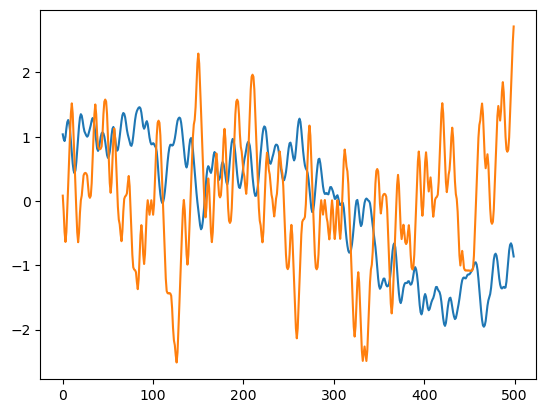

In [21]:
# Factor 2 represents the velocity of the cart.
primary_factor = test_state @ evec[:, 1]
s_primary_factor = (primary_factor - primary_factor.mean()) / primary_factor.std()
s_primary_factor = gaussian_filter(s_primary_factor, sigma=1)
s_actions = (cart_velocity - cart_velocity.mean()) / cart_velocity.std()
s_actions = gaussian_filter(s_actions, sigma=1)
plt.plot(np.arange(lifespans[0] + 1), s_primary_factor)
plt.plot(np.arange(lifespans[0] + 1),  1 * s_actions)

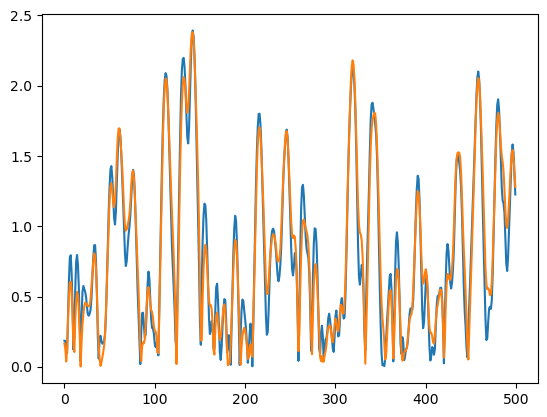

In [22]:
# Factor 1 represents the absolute position of the pole.
primary_factor = test_state @ evec[:, 0]
s_primary_factor = (primary_factor - primary_factor.mean()) / primary_factor.std()
s_primary_factor = gaussian_filter(s_primary_factor, sigma=1)
s_actions = (pole_pos - pole_pos.mean()) / pole_pos.std()
s_actions = gaussian_filter(s_actions, sigma=1)
plt.plot(np.arange(lifespans[0] + 1), np.abs(s_primary_factor))
plt.plot(np.arange(lifespans[0] + 1), np.abs(s_actions))

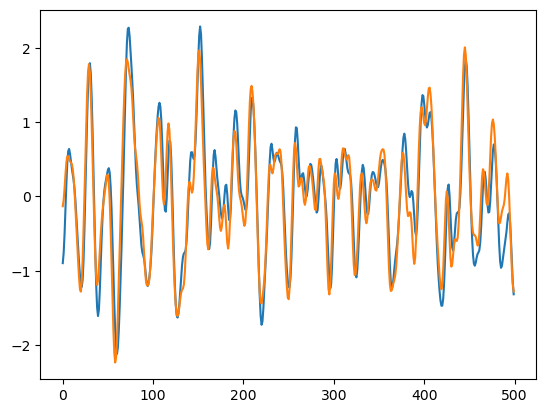

In [42]:
# Factor 1 represents the velocity of the pole.
primary_factor = test_state @ evec[:, 2]
s_primary_factor = (primary_factor - primary_factor.mean()) / primary_factor.std()
s_primary_factor = gaussian_filter(s_primary_factor, sigma=2)
s_actions = (pole_velocity - pole_velocity.mean()) / pole_velocity.std()
s_actions = gaussian_filter(s_actions, sigma=2)
plt.plot(np.arange(lifespans[0] + 1), s_primary_factor)
plt.plot(np.arange(lifespans[0] + 1), -1 * s_actions)